# **MANMEET KAUR - 101803095**
# **SUKHMAN SINGH - 101803097**
# **PRAJJWAL UPADHYAY - 101803111**
## **COE - 06**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


import the libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder

https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset/

Download dataset
and read it

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/AI_LAB/data_1.zip", 'r')
zip_ref.extractall()
zip_ref.close()

[[ 27  63 144 144]]


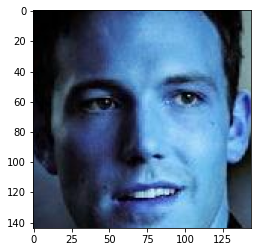

In [ ]:
#detecting a face from an image from one example

face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/AI_LAB/haar.xml')
f = cv2.imread("/content/data_1/data/train/ben_afflek/httpabsolumentgratuitfreefrimagesbenaffleckjpg.jpg")
faces = face_cascade.detectMultiScale(f,1.3,5)
print(faces)
for x,y,w,h in faces:
    plt.imshow(f[y:y+h, x:x+w])

Create dataset

In [ ]:
#detecting a face from an image from training data

face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/AI_LAB/haar.xml')
dirs = "/content/data_1/data/train/"
img_size = 60

data = []
for name in os.listdir(dirs):
    for f in os.listdir(dirs+name):
        f = cv2.imread(os.path.join(dirs+name, f))
        faces = face_cascade.detectMultiScale(f,1.3,5)
        for x,y,w,h in faces:
            img = f[y:y+h, x:x+w]
            img = cv2.resize(img, (img_size,img_size))
            data.append((img, name))
            
df = pd.DataFrame(data, columns=["image", "name"])
print("Length:",len(df))

Length: 140


Name:  madonna
(60, 60, 3)


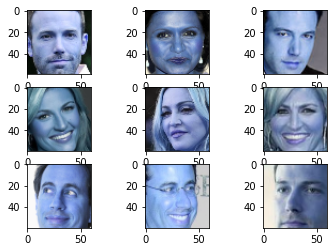

In [ ]:
# visualizing the df dataframe randomly

idx = 34
row = df.iloc[idx, :]
print("Name: ", row["name"])
print(row.image.shape)
for i in range(9):
  row = df.iloc[np.random.randint(0, len(df)), :]
  plt.subplot(3,3,i+1)
  plt.imshow(row.image)

create test data

In [ ]:
#detecting face in testing data

dirs = "/content/data_1/data/val/"

data = []
for name in os.listdir(dirs):
    for f in os.listdir(dirs+name):
        f = cv2.imread(os.path.join(dirs+name, f))
        faces = face_cascade.detectMultiScale(f,1.3,5)
        for x,y,w,h in faces:
            img = f[y:y+h, x:x+w]
            img = cv2.resize(img, (img_size,img_size))
            data.append((img, name))
            
df_test = pd.DataFrame(data, columns=["image", "name"])
print("Test size: ", len(df_test))


Test size:  35


## Preprocess data

In [ ]:
#label encoding on names

le = LabelEncoder()
le.fit(df["name"].values)

LabelEncoder()

Training data

In [ ]:
#training data formation

x_train = list(df.image.values)
x_train = np.array(x_train)
x_train = x_train/255
print(x_train.shape)

y_train = le.transform(df["name"].values)
print(y_train.shape)

(140, 60, 60, 3)
(140,)


Testing data

In [ ]:
#testing data formation

x_test = list(df_test.image.values)
x_test = np.array(x_test)
x_test = x_test/255
print(x_test.shape)

y_test = le.transform(df_test["name"].values)
print(y_test.shape)

(35, 60, 60, 3)
(35,)


In [ ]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(140, 60, 60, 3) (140,)
(35, 60, 60, 3) (35,)


## Prepare and Fit Models

In [ ]:
#unique people count
people_num = len(np.unique(y_train))
people_num

7

#### Normal Model

In [ ]:
#model defining without triplet loss

def get_model():
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(img_size,img_size,3), activation='relu'))
        model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
        model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
        model.add(tf.keras.layers.Conv2D(64, kernel_size=1, strides=2, padding='same', activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(256, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(people_num, activation="softmax"))
        model.summary()
        return model

In [ ]:
#creating a tensorflow graph and choosing the optimizer and loss function
from tensorflow.python.framework import ops
ops.reset_default_graph()
model = get_model()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          4160      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               6

In [ ]:
#saving checkpoints for future use

weight_dir = "weight_normal_model"
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
    
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_dir+'/checkpoint-{epoch:02d}.hdf5')

In [ ]:
#fitting the model
history = model.fit(x_train,y_train,validation_data=(x_test, y_test),epochs=40, batch_size=100, callbacks=[checkpoint])

Epoch 1/40
2/2 [==============================] - 32s 468ms/step - loss: 1.9557 - accuracy: 0.1143 - val_loss: 1.9448 - val_accuracy: 0.2000
Epoch 2/40
2/2 [==============================] - 0s 27ms/step - loss: 1.9391 - accuracy: 0.2000 - val_loss: 1.9455 - val_accuracy: 0.1429
Epoch 3/40
2/2 [==============================] - 0s 28ms/step - loss: 1.9308 - accuracy: 0.2000 - val_loss: 1.9505 - val_accuracy: 0.1429
Epoch 4/40
2/2 [==============================] - 0s 26ms/step - loss: 1.9354 - accuracy: 0.1714 - val_loss: 1.9476 - val_accuracy: 0.1429
Epoch 5/40
2/2 [==============================] - 0s 29ms/step - loss: 1.9252 - accuracy: 0.1857 - val_loss: 1.9372 - val_accuracy: 0.1429
Epoch 6/40
2/2 [==============================] - 0s 28ms/step - loss: 1.9165 - accuracy: 0.1786 - val_loss: 1.9315 - val_accuracy: 0.1429
Epoch 7/40
2/2 [==============================] - 0s 28ms/step - loss: 1.9064 - accuracy: 0.1929 - val_loss: 1.9285 - val_accuracy: 0.1429
Epoch 8/40
2/2 [=========

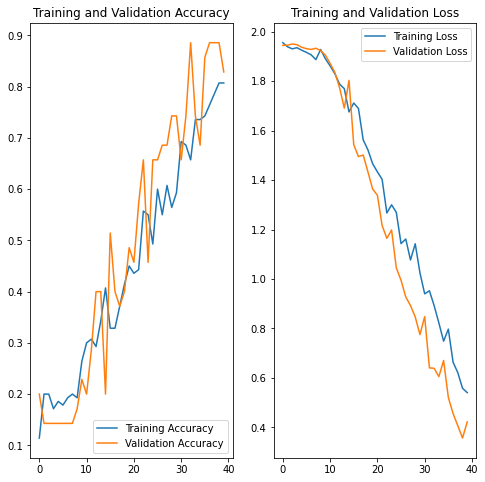

In [ ]:
#model evaluation using plots

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#generating triplets

def generate_triplets(x, y, num_same = 4, num_diff = 4):
    anchor_images = np.array([]).reshape((-1,)+ x.shape[1:])
    same_images = np.array([]).reshape((-1,)+ x.shape[1:])
    diff_images = np.array([]).reshape((-1,)+ x.shape[1:])
    
    for i in range(len(y)):
        point = y[i]        
        anchor = x[i]
        
        same_pairs = np.where(y == point)[0]
        same_pairs = np.delete(same_pairs , np.where(same_pairs == i))
        diff_pairs = np.where(y != point)[0]
               
        same = x[np.random.choice(same_pairs,num_same)]
        diff = x[np.random.choice(diff_pairs,num_diff)]
        
        anchor_images = np.concatenate((anchor_images, np.tile(anchor, (num_same * num_diff, 1, 1, 1) )), axis = 0)
                                       
        for s in same:
            same_images = np.concatenate((same_images, np.tile(s, (num_same, 1, 1, 1) )), axis = 0)
            
        diff_images = np.concatenate((diff_images, np.tile(diff, (num_diff, 1, 1, 1) )), axis = 0)
        
    return anchor_images, same_images, diff_images

In [ ]:
#triplet dataset in required format

anchor_images, same_images, diff_images = generate_triplets(x_train,y_train, num_same= 10, num_diff=10)
print(anchor_images.shape, same_images.shape, diff_images.shape)

(14000, 60, 60, 3) (14000, 60, 60, 3) (14000, 60, 60, 3)


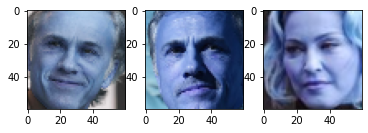

In [ ]:
#random checking triplet functions on single image

idx = 90
plt.subplot(1,3,1)
plt.imshow(anchor_images[idx])

plt.subplot(1,3,2)
plt.imshow(same_images[idx])

plt.subplot(1,3,3)
plt.imshow(diff_images[idx])

#### Using Triplet Loss

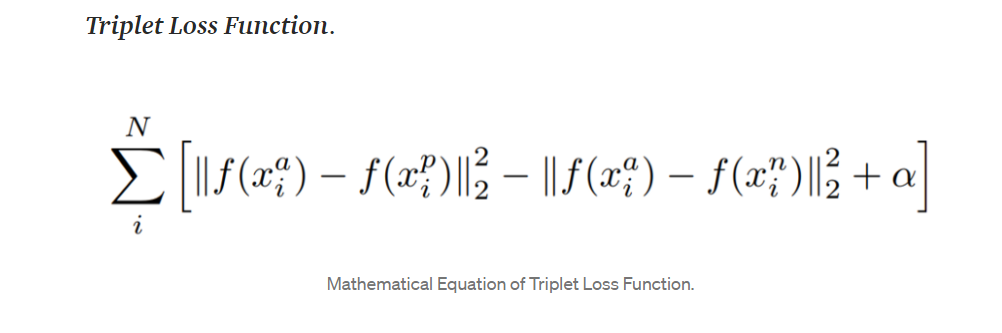

In [ ]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    total_lenght = y_pred.shape.as_list()[-1]
    anchor, positive, negative = y_pred[:,:int(1/3*total_lenght)], y_pred[:,int(1/3*total_lenght):int(2/3*total_lenght)], y_pred[:,int(2/3*total_lenght):]
    
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))
    return loss

In [ ]:
#defining model with triplet loss

def get_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(img_size,img_size,3), activation='relu'))
  model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
  model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
  model.add(tf.keras.layers.Conv2D(64, kernel_size=1, strides=2, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(128))
  model.summary()
  return model

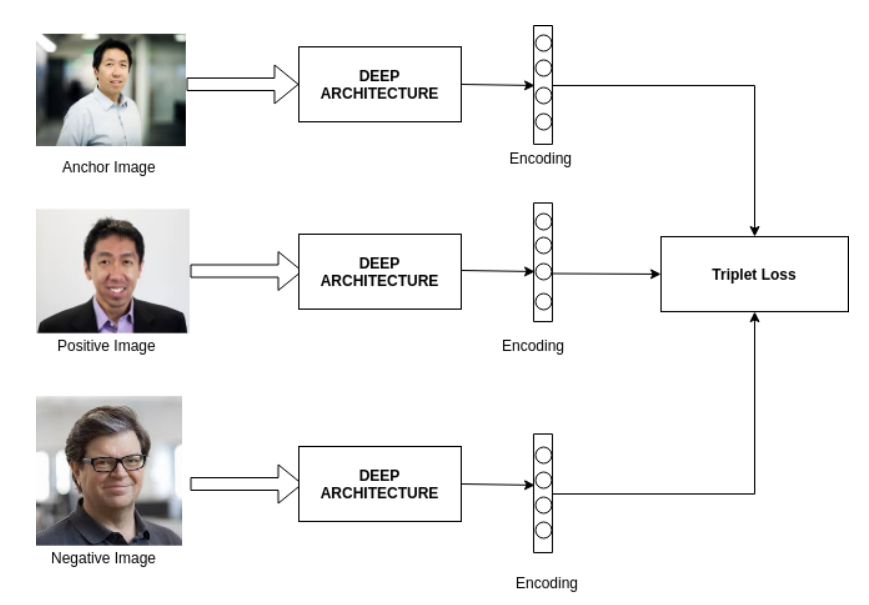

In [ ]:
#shared dnn for anchor negative and positive image

from tensorflow.python.framework import ops
ops.reset_default_graph()
anchor_input = tf.keras.layers.Input((img_size, img_size, 3), name='anchor_input')
positive_input = tf.keras.layers.Input((img_size, img_size, 3), name='positive_input')
negative_input = tf.keras.layers.Input((img_size, img_size, 3), name='negative_input')

shared_dnn = get_model()

encoded_anchor = shared_dnn(anchor_input)
encoded_positive = shared_dnn(positive_input)
encoded_negative = shared_dnn(negative_input)

merged_vector = tf.keras.layers.concatenate([encoded_anchor, encoded_positive, encoded_negative],axis=-1, name='merged_layer')

model = tf.keras.Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.summary()
model.compile(loss=triplet_loss, optimizer="adam")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          4160      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               6

In [ ]:
#saving checkpoints
weight_dir = "weight_tripletloss_model"
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
    
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_dir+'/checkpoint-{epoch:02d}.hdf5')

In [ ]:
#fitting our model for triplet loss
Y_dummy = np.empty((anchor_images.shape[0],1))

history = model.fit([anchor_images,same_images,diff_images],y=Y_dummy, batch_size=128, epochs=45, callbacks=[checkpoint])

Epoch 1/45
110/110 [==============================] - 6s 47ms/step - loss: 16.6496
Epoch 2/45
110/110 [==============================] - 5s 45ms/step - loss: 3.7117
Epoch 3/45
110/110 [==============================] - 5s 45ms/step - loss: 2.3931
Epoch 4/45
110/110 [==============================] - 5s 45ms/step - loss: 2.0356
Epoch 5/45
110/110 [==============================] - 5s 44ms/step - loss: 1.3882
Epoch 6/45
110/110 [==============================] - 5s 43ms/step - loss: 1.3288
Epoch 7/45
110/110 [==============================] - 5s 43ms/step - loss: 0.7394
Epoch 8/45
110/110 [==============================] - 5s 43ms/step - loss: 0.8743
Epoch 9/45
110/110 [==============================] - 5s 42ms/step - loss: 0.6448
Epoch 10/45
110/110 [==============================] - 5s 42ms/step - loss: 0.6086
Epoch 11/45
110/110 [==============================] - 5s 42ms/step - loss: 0.5750
Epoch 12/45
110/110 [==============================] - 4s 41ms/step - loss: 0.2873
Epoch 13/45


In [ ]:
#model
anchor_model = tf.keras.Model(inputs = anchor_input, outputs=encoded_anchor)

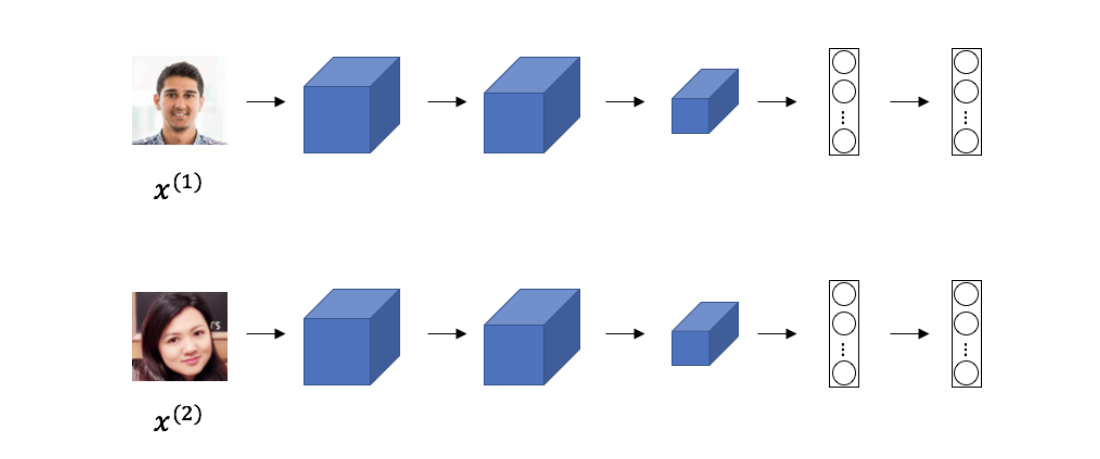

In [ ]:
#predicting through our model

pred = anchor_model.predict(x_train)
pred.shape

(140, 128)

In [ ]:
x=pred
y=y_train

In [ ]:
x[0]

array([ 0.1357509 , -0.04834836,  0.1462268 ,  0.01517729, -0.03019092,
       -0.08081107, -0.23536327,  0.106244  ,  0.23012386,  0.02106989,
       -0.0704563 , -0.2327644 , -0.19589485, -0.04617068,  0.09867986,
        0.14492084, -0.18581703, -0.16921243,  0.07137518,  0.07276145,
       -0.05660206,  0.2026665 ,  0.08654529,  0.29039937,  0.02187411,
        0.02770797, -0.06028875, -0.21050046, -0.00512795,  0.24434988,
       -0.04721555, -0.2700255 , -0.20439015,  0.06421338,  0.05166581,
        0.17871456,  0.03911386, -0.14087576, -0.08624697,  0.11906221,
       -0.09173486,  0.05375196, -0.16374265,  0.02625524, -0.02004304,
        0.12623687, -0.04261689, -0.03952545, -0.21224767, -0.04700905,
       -0.11201139, -0.07382036,  0.1768226 , -0.07802343,  0.01410176,
        0.06031454, -0.09425226,  0.03820741,  0.06267668, -0.04018734,
       -0.15798809,  0.2374837 , -0.1203371 ,  0.14945313, -0.3044607 ,
       -0.25416324,  0.32657763,  0.13367394,  0.20533526,  0.16

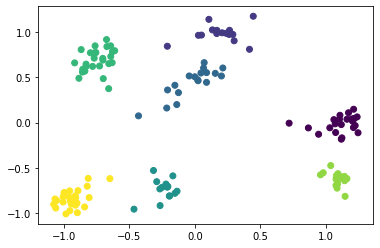

In [ ]:
#applying PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pred_pca = pca.fit_transform(pred)

customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139',"#FFF000",'#D24D57','#F7CA18']
plt.scatter(pred_pca[:,0], pred_pca[:,1], c=y_train)

In [ ]:
#encoding the image for face recognition

def encode_image(model ,img):
    encode = model.predict(img.reshape((1,)+ img.shape))
    return encode

In [ ]:
# getting the center of each cluster in the classes

name_dict = {}
for i in set(df["name"].values):
    z = df[df["name"] == i].image
    img = np.array(list(z))/255
    enc = np.zeros((1,128))
    for j in range(len(z)):
        enc += encode_image(anchor_model,img[j])
    enc = enc/len(z)
    name_dict[i] = enc

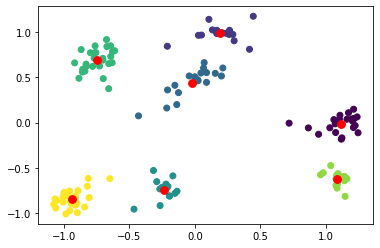

In [ ]:
#centres for each cluster

pca = PCA(n_components=2)
pred_pca = pca.fit_transform(pred)

plt.scatter(pred_pca[:,0], pred_pca[:,1], c=y_train)

for val in name_dict.values():
  point = pca.transform(val)
  plt.scatter(point[0,0], point[0,1], s = [60], c='red')
plt.show()

In [ ]:
#distance function
      
def dist_imgs(anchor_enc, img_enc):
    return np.linalg.norm(img_enc - anchor_enc)

In [ ]:
#nearby image of a particular image implementation
def predict_image(model, img, dictionary):
    enc = encode_image(model, img)
    max_dist = 10000000
    max_name = None
    for name in dictionary:
        dist = dist_imgs(dictionary[name], enc)
        if max_dist > dist:
            max_dist = dist
            max_name = name
    
    return max_name, max_dist

Predicted name: mindy_kaling  with distance 0.24002621114703235
Actual pred:  ['mindy_kaling']


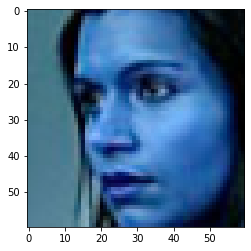

In [ ]:
#custom knn like model

idx = 80
img = x_train[idx]
plt.imshow(img)

n, d = predict_image(anchor_model, img, name_dict)
print("Predicted name:",n ," with distance", d)
print("Actual pred: ", le.inverse_transform(y_train[idx:idx+1]))

## **USING KNN ALGO ON ENCODINGS**

In [ ]:
pred_x_train = anchor_model.predict(x_train)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(pred_x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

Actual Image


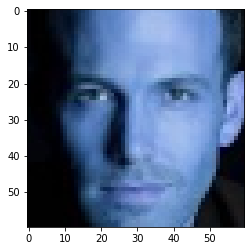

In [ ]:
# neigh.kneighbours - database indices of images that are matching with my image

idx = 25
img = x_test[idx]
print("Actual Image")
plt.imshow(img)

enc = encode_image(anchor_model, img)
preds = neigh.kneighbors(enc, return_distance=False)

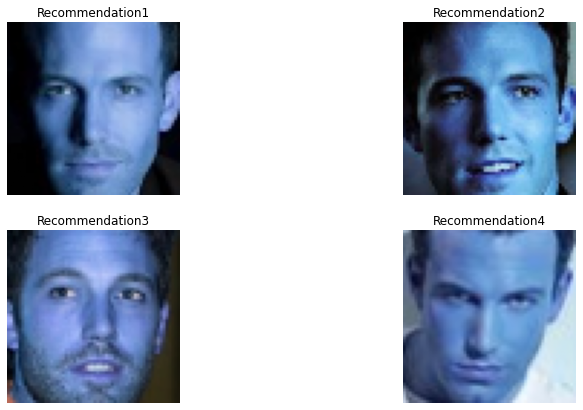

In [ ]:
fig = plt.figure(figsize=(13, 7))
rows = 2
columns = 2

for i in range(0,preds[0].shape[0]):
  img1 = x_train[preds[0][i]]
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img1)
  plt.axis('off')
  plt.title("Recommendation"+str(i+1))

<class 'numpy.ndarray'>
Predicted name: ['christoph_waltz']
Actual pred:  ['christoph_waltz']


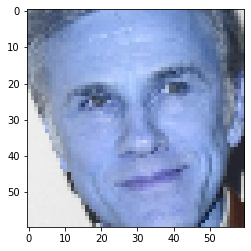

In [ ]:
# Predicts the name of the image

idx = 5
img = x_test[idx]
plt.imshow(img)

enc = encode_image(anchor_model, img)
pred = neigh.predict(enc)

print("Predicted name:",le.inverse_transform(pred))
print("Actual pred: ", le.inverse_transform(y_test[idx:idx+1]))

In [ ]:
pred_x_test = anchor_model.predict(x_test)
pred = neigh.predict(pred_x_test)
print(np.sum(pred == y_test)/len(pred))

0.8857142857142857


## **IMAGE WITH MULTIPLE FACES PREDICTED**

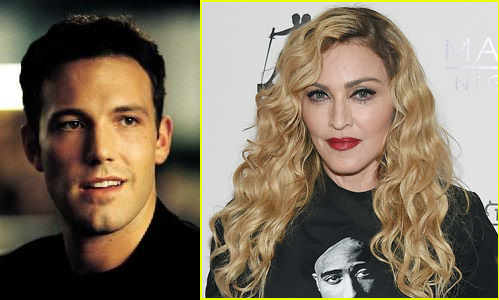

In [ ]:
#multiple people in a single image testing
datamultiple=[]

f = cv2.imread('/content/drive/MyDrive/testingimage.jpeg')
faces = face_cascade.detectMultiScale(f,1.3,5)
for x,y,w,h in faces:
  img = f[y:y+h, x:x+w]
  img = cv2.resize(img, (img_size,img_size))
  datamultiple.append((img))

<Figure size 432x288 with 0 Axes>

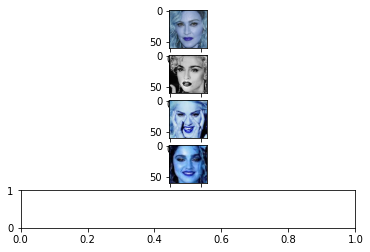

<Figure size 432x288 with 0 Axes>

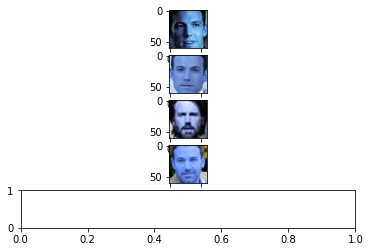

In [ ]:
#recommending similar images for multiple faces in a single image
for img in datamultiple:
  enc = encode_image(anchor_model, img)
  preds = neigh.kneighbors(enc, return_distance=False)   
  preds=preds[:,0:3]
  plt.figure()
  f, axarr = plt.subplots(5,1) 
  axarr[0].imshow(img)
  for i in range(0,preds[0].shape[0]):
    img1 = x_train[preds[0][i]]
    axarr[i+1].imshow(img1)